<a href="https://colab.research.google.com/github/vaibhav016/Mini_Project_2022/blob/main/HyperParameter_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code taken from the 1st assignemnt and the link given below.

### Imports

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.utils.data as data
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import _LRScheduler, ReduceLROnPlateau, LinearLR, ExponentialLR, CosineAnnealingLR
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import copy
import random
import time

In [4]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
# torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)

In [6]:
#function for deterministic dataloader
def seed_worker(worker_id):
    worker_seed =  SEED # torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

### Dataset Creation

In [7]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

In [8]:
#Taken from prev assignment
train_transforms = transforms.Compose(
        [
            transforms.RandomRotation(5),
            transforms.RandomCrop((32,32), padding=4),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])

test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),    
        ])

In [9]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=train_transforms, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=test_transforms, download=True)

# train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Model Architecture 
Taken from https://github.com/kuangliu/pytorch-cifar 
Link given in the assignment


In [10]:
class BasicBlock(nn.Module):
    
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [11]:
class ResNet(nn.Module):
    def __init__(self, block, ip_planes, num_blocks, kernel_size=3, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=kernel_size,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, ip_planes[0], num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, ip_planes[1], num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, ip_planes[2], num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, ip_planes[3], num_blocks[3], stride=2)
        self.linear = nn.Linear(ip_planes[3], num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [12]:
def build_model(ip_planes = [64,128,256,512], blocks = [1,1,1,1], kernel_sz=3): #ip_planes = [64,128,128,256], blocks = [3,3,2,3]
    return ResNet(BasicBlock, ip_planes, blocks, kernel_sz)

In [13]:
model = build_model()

In [14]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

4903242

In [18]:
def calculate_metrics(y_pred, y):
    top_pred = torch.squeeze(y_pred.argmax(1, keepdim = True), 1)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    
    # print('top_pred shape: ', top_pred.shape)
    # print('top_pred: ', top_pred)
    # print('y shape: ', y.shape)
    # print('y: ', y)

    prec = precision_score(y.cpu(), top_pred.cpu(), average='micro', zero_division = 0)

    rec = recall_score(y.cpu(), top_pred.cpu(), average='micro', zero_division = 0)

    f1 = f1_score(y.cpu(), top_pred.cpu(), average='micro', zero_division = 0)

    # print('prec: ', prec, ' Recall: ', rec, ' f1: ', f1)

    return acc, prec, rec, f1

In [19]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_rec = 0
    epoch_f1 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        # print(device)

        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc, prec, rec, f1 = calculate_metrics(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_prec += prec.item()
        epoch_rec += rec.item()
        epoch_f1 += f1.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_prec / len(iterator), epoch_rec / len(iterator), epoch_f1 / len(iterator)

In [20]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_rec = 0
    epoch_f1 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc, prec, rec, f1 = calculate_metrics(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_prec += prec.item()
            epoch_rec += rec.item()
            epoch_f1 += f1.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_prec / len(iterator), epoch_rec / len(iterator), epoch_f1 / len(iterator)

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [23]:
def training_loop(epochs, model, train_dataloader, valid_dataloader, test_dataloader, optimizer, scheduler, criterion, device, exp_type, model_path, exp_identifier = ''):
  
  #initialize minimum loss
  validation_loss_min = torch.inf
  
  #Initialize lists to store losses and accuracies
  train_losses = []
  train_accuracies = []
  train_precs = []
  train_recs = []
  train_f1s = []
  val_losses = []
  val_accuracies = []
  val_precs = []
  val_recs = []
  val_f1s = []
  test_losses = []
  test_accuracies = []
  test_precs = []
  test_recs = []
  test_f1s = []
  lrs = []

  #initialize tolerance
  # tolerance = 30
  # tolerance_start_counter = 0

  # Fill training code here  
  print('Training beginning for experiments on ' + exp_type + ' ' + str(exp_identifier) + '....')
  
  for i in range(epochs):
    start_time = time.time()
    training_loss, training_accuracy, training_prec, training_rec, training_f1 = train(model, train_dataloader, optimizer, criterion, device)
    train_end_time = time.time()
    validation_loss, validation_accuracy, validation_prec, validation_rec, validation_f1 = evaluate(model,valid_dataloader, criterion, device)
    val_end_time = time.time()

    #take a scheduler step for this epoch
    scheduler.step(validation_loss)

    #Calculate training and validation times
    train_elapsed_mins, train_elapsed_secs = epoch_time(start_time, train_end_time)
    val_elapsed_mins, val_elapsed_secs = epoch_time(train_end_time, val_end_time)

    #save losses and accuracies
    train_losses.append(training_loss)
    train_accuracies.append(training_accuracy)
    train_precs.append(training_prec)
    train_recs.append(training_rec)
    train_f1s.append(training_f1)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)
    val_precs.append(validation_prec)
    val_recs.append(validation_rec)
    val_f1s.append(validation_f1)
    lrs.append(optimizer.param_groups[0]['lr'])

    print('epoch: %d | train time: %d mins %d secs | train_loss: %.2f| train_accuracy: %.2f | val time: %d mins %.d secs | valid_loss: %.2f | valid_accuracy: %.2f | lr: %6f'%(i+1, train_elapsed_mins, \
                                                                                                                                                                            train_elapsed_secs, \
                                                                                                                                                                            training_loss, \
                                                                                                                                                                            training_accuracy, \
                                                                                                                                                                            val_elapsed_mins, \
                                                                                                                                                                            val_elapsed_secs, \
                                                                                                                                                                            validation_loss, \
                                                                                                                                                                            validation_accuracy, 
                                                                                                                                                                            optimizer.param_groups[0]['lr']))
    
  
    #get test losses and accuracies for storing and plotting
    testing_loss, testing_accuracy, testing_prec, testing_rec, testing_f1 = evaluate(model,test_dataloader, criterion, device)
    test_losses.append(testing_loss)
    test_accuracies.append(testing_accuracy)
    test_precs.append(testing_prec)
    test_recs.append(testing_rec)
    test_f1s.append(testing_f1)
    
    if validation_loss < validation_loss_min:
      print('Saving model ...')
      validation_loss_min = validation_loss
      torch.save({
              'epoch': i+1,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': validation_loss,
              }, model_path)
      #reset tolerance counter
      # tolerance_start_counter = 0
    # else:
    #   # Implementing early stopping
    #   tolerance_start_counter += 1
    #   if tolerance_start_counter == tolerance:
    #       print("Early Stopping at epoch ", i + 1)
    #       break
    
  print('Training Completed for experiments on ' + exp_type + ' ' + str(exp_identifier) + '!')

  #load best model
  model.load_state_dict(torch.load(model_path)['model_state_dict'])

  #Testing
  testing_loss, testing_accuracy, testing_prec, testing_rec, testing_f1 = evaluate(model, test_dataloader, criterion, device)
  print("testing loss: %.2f | testing accuracy: %.2f"%(testing_loss, testing_accuracy))


  return train_losses, train_accuracies, train_precs, train_recs, train_f1s, val_losses, val_accuracies, val_precs, val_recs, val_f1s, test_losses, test_accuracies, test_precs, test_recs, test_f1s, lrs

In [24]:
def plot_train_performance(train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies, exp_type, exp_identifier = ''):
  #Plot accuracies and losses for train and val
  fig, axs = plt.subplots(1, 2, sharex = True)

  fig.set_figheight(10)
  fig.set_figwidth(15)
  fig.suptitle('Experiment for ' + exp_type + ' ' + str(exp_identifier))

  axs[0].plot(train_losses)
  axs[0].plot(val_losses)
  axs[0].plot(test_losses)

  #Plot minimum losses
  min_train_loss = min(train_losses)
  min_train_loss_epoch = train_losses.index(min_train_loss)
  axs[0].plot(min_train_loss_epoch, min_train_loss, marker="o", markersize=7)
  axs[0].text(min_train_loss_epoch, min_train_loss,str(round(min_train_loss, 3)))

  min_val_loss = min(val_losses)
  min_val_loss_epoch = val_losses.index(min_val_loss)
  axs[0].plot(min_val_loss_epoch, min_val_loss, marker="o", markersize=7)
  axs[0].text(min_val_loss_epoch, min_val_loss,str(round(min_val_loss, 3)))

  min_test_loss = min(test_losses)
  min_test_loss_epoch = test_losses.index(min_test_loss)
  axs[0].plot(min_test_loss_epoch, min_test_loss, marker="o", markersize=7)
  axs[0].text(min_test_loss_epoch, min_test_loss,str(round(min_test_loss, 3)))

  axs[0].set_title('model losses per epoch')
  axs[0].set_ylabel('loss')
  axs[0].set_xlabel('epoch')
  axs[0].legend(['train', 'val', 'test'])


  axs[1].plot(train_accuracies)
  axs[1].plot(val_accuracies)
  axs[1].plot(test_accuracies)

  #plot maximum accuracies
  max_train_acc = max(train_accuracies)
  max_train_acc_epoch = min_train_loss_epoch
  axs[1].plot(max_train_acc_epoch, max_train_acc, marker="o", markersize=7)
  axs[1].text(max_train_acc_epoch, max_train_acc, str(round(max_train_acc*100, 3)))

  max_val_acc = max(val_accuracies)
  max_val_acc_epoch = min_val_loss_epoch
  axs[1].plot(max_val_acc_epoch, max_val_acc, marker="o", markersize=7)
  axs[1].text(max_val_acc_epoch, max_val_acc, str(round(max_val_acc*100, 2)))

  max_test_acc = max(test_accuracies)
  max_test_acc_epoch = min_test_loss_epoch
  axs[1].plot(max_test_acc_epoch, max_test_acc, marker="o", markersize=7)
  axs[1].text(max_test_acc_epoch, max_test_acc, str(round(max_test_acc*100, 2)))

  axs[1].set_title('model accuracies per epoch')
  axs[1].set_ylabel('accuracy')
  axs[1].set_xlabel('epoch')
  axs[1].legend(['train', 'val', 'test'])

  plt.savefig('drive/MyDrive/DLMiniProject/OutputGraphs/train_performance_' + exp_type + '_' + str(exp_identifier) + '.png')

  fig.show()

In [25]:
#Function to save training summary
def save_train_summary(epochs, train_losses, train_accuracies, train_precs, train_recs, train_f1s, val_losses, val_accuracies, val_precs, val_recs, val_f1s, test_losses, test_accuracies, test_precs, test_recs, test_f1s, lrs, exp_type, exp_identifier = ''):

  epoch_range = [i for i in range(epochs)]

  df = pd.DataFrame(list(zip(epoch_range,
                             train_losses,
                             train_accuracies, 
                             train_precs, 
                             train_recs, 
                             train_f1s, 
                             val_losses, 
                             val_accuracies, 
                             val_precs, 
                             val_recs, 
                             val_f1s, 
                             test_losses, 
                             test_accuracies, 
                             test_precs, 
                             test_recs, 
                             test_f1s,
                             lrs)),
                    columns = ['epoch', 'train_losses', 'train_acc', 'train_prec', 'train_rec', 'train_f1',
                               'val_loss', 'val_acc', 'val_prec', 'val_rec', 'val_f1',
                               'test_loss', 'test_acc', 'test_prec', 'test_rec', 'test_f1', 'learning_rate'])
  
  df.to_csv('drive/MyDrive/DLMiniProject/TrainingSummary/TrainSummary_' + str(exp_type) + '_' + str(exp_identifier) + '.csv')



In [26]:
#from numpy.ma.core import exp
def experiment_training(epochs, model, train_dataloader, valid_dataloader, test_dataloader, optimizer, scheduler, criterion, device, hyperGrid, exp_type = 'epoch'):

  EPOCHS = epochs
  validation_loss_min = torch.inf

  model_base_path = "drive/MyDrive/DLMiniProject/Models/model"


  if exp_type == 'epoch':
    #construct model path
    model_path = model_base_path + '_' + exp_type + '.pt'
    
    #Train
    (train_losses, 
     train_accuracies, 
     train_precs, 
     train_recs, 
     train_f1s, 
     val_losses, 
     val_accuracies, 
     val_precs, 
     val_recs, 
     val_f1s, 
     test_losses, 
     test_accuracies, 
     test_precs, 
     test_recs, 
     test_f1s,
     lrs) = training_loop(epochs,
                               model, 
                               train_dataloader, 
                               valid_dataloader, 
                               test_dataloader, 
                               optimizer,
                               scheduler, 
                               criterion, 
                               device, 
                               exp_type, 
                               model_path)
    #plot the losses and accuracies
    plot_train_performance(train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies, exp_type)

    #Save Training Summary
    save_train_summary(epochs,
                       train_losses, 
                       train_accuracies, 
                       train_precs, 
                       train_recs, 
                       train_f1s, 
                       val_losses, 
                       val_accuracies, 
                       val_precs, 
                       val_recs, 
                       val_f1s, 
                       test_losses, 
                       test_accuracies, 
                       test_precs, 
                       test_recs, 
                       test_f1s,
                       lrs,
                       exp_type)

  elif exp_type == 'optimizer':

    optimizers = hyperGrid['optimizer']
    
    #Set Criterion
    criterion = nn.CrossEntropyLoss().to(device)

    for optim_name in optimizers:
        
        #Get a new instance of the model
        model = build_model()
        model = model.to(device)
        
        if optim_name == 'Adam':
          optimizer = optim.Adam(model.parameters(), lr = 0.1, weight_decay = 0.0001)
        elif optim_name == 'AdamW':
          optimizer = optim.AdamW(model.parameters(), lr = 0.1, weight_decay = 0.0001)
        elif optim_name == 'SGD':
          optimizer = optim.SGD(model.parameters(), lr = 0.1, weight_decay = 0.0001, momentum = 0.9)
        elif optim_name == 'RMSprop':
          optimizer = optim.RMSprop(model.parameters(), lr = 0.1, weight_decay = 0.0001, momentum = 0.9)

        #set scheduler
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1)

        #construct model path
        model_path = model_base_path + '_' + exp_type + '_' + optim_name + '.pt'
        
        #Train
        (train_losses, 
        train_accuracies, 
        train_precs, 
        train_recs, 
        train_f1s, 
        val_losses, 
        val_accuracies, 
        val_precs, 
        val_recs, 
        val_f1s, 
        test_losses, 
        test_accuracies, 
        test_precs, 
        test_recs, 
        test_f1s,
        lrs) = training_loop(epochs,
                                  model, 
                                  train_dataloader, 
                                  valid_dataloader, 
                                  test_dataloader, 
                                  optimizer,
                                  scheduler, 
                                  criterion,
                                  device, 
                                  exp_type, 
                                  model_path,
                                  optim_name)
        
        #plot the losses and accuracies
        plot_train_performance(train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies, exp_type, optim_name)

        #Save Training Summary
        save_train_summary(epochs,
                           train_losses, 
                           train_accuracies, 
                           train_precs, 
                           train_recs, 
                           train_f1s, 
                           val_losses, 
                           val_accuracies, 
                           val_precs, 
                           val_recs, 
                           val_f1s, 
                           test_losses, 
                           test_accuracies, 
                           test_precs, 
                           test_recs, 
                           test_f1s,
                           lrs,
                           exp_type,
                           optim_name)

        #delete model from gpu
        del model

  elif exp_type == 'learning_rate':

    learning_rates = hyperGrid['learning_rate']
    
    #Set Criterion
    criterion = nn.CrossEntropyLoss().to(device)

    for lrate in  learning_rates:

        #Get a new instance of the model
        model = build_model()
        model = model.to(device)

        #set optimizer
        optimizer = optim.SGD(model.parameters(), lr = lrate, weight_decay= 0.0001, momentum = 0.9)

        #set scheduler
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1)


        #construct model path
        model_path = model_base_path + '_' + exp_type + '_' + str(lrate) + '.pt'
        
        #Train
        (train_losses, 
        train_accuracies, 
        train_precs, 
        train_recs, 
        train_f1s, 
        val_losses, 
        val_accuracies, 
        val_precs, 
        val_recs, 
        val_f1s, 
        test_losses, 
        test_accuracies, 
        test_precs, 
        test_recs, 
        test_f1s,
        lrs) = training_loop(epochs,
                                  model, 
                                  train_dataloader, 
                                  valid_dataloader, 
                                  test_dataloader, 
                                  optimizer,
                                  scheduler, 
                                  criterion, 
                                  device, 
                                  exp_type, 
                                  model_path,
                                  lrate)
        
        #plot the losses and accuracies
        plot_train_performance(train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies, exp_type, lrate)

        #Save Training Summary
        save_train_summary(epochs,
                           train_losses, 
                           train_accuracies, 
                           train_precs, 
                           train_recs, 
                           train_f1s, 
                           val_losses, 
                           val_accuracies, 
                           val_precs, 
                           val_recs, 
                           val_f1s, 
                           test_losses, 
                           test_accuracies, 
                           test_precs, 
                           test_recs, 
                           test_f1s,
                           lrs,
                           exp_type,
                           lrate)

        #delete model from gpu
        del model

  elif exp_type == 'batch_size':

    batch_sizes = hyperGrid['batch_size']
    
    #Set Criterion
    criterion = nn.CrossEntropyLoss().to(device)

    for b_size in  batch_sizes:
        
        #Reset Seed
        torch.manual_seed(SEED)

        #Construct Train Data loader Data Loaders with current batch size
        train_dataloader = DataLoader(train_data, batch_size=b_size, shuffle=True, num_workers=2, worker_init_fn = seed_worker, generator = g)
        
        #Get a new instance of the model
        model = build_model()
        model = model.to(device)

        #Set Optimizer
        optimizer = optim.SGD(model.parameters(), lr = 0.1, weight_decay = 0.0001, momentum = 0.9)

        #Set Scheduler
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1)

        #construct model path
        model_path = model_base_path + '_' + exp_type + '_' + str(b_size) + '.pt'
        
        #Train
        (train_losses, 
        train_accuracies, 
        train_precs, 
        train_recs, 
        train_f1s, 
        val_losses, 
        val_accuracies, 
        val_precs, 
        val_recs, 
        val_f1s, 
        test_losses, 
        test_accuracies, 
        test_precs, 
        test_recs, 
        test_f1s,
        lrs) = training_loop(epochs,
                                  model, 
                                  train_dataloader, 
                                  valid_dataloader, 
                                  test_dataloader, 
                                  optimizer,
                                  scheduler,
                                  criterion, 
                                  device, 
                                  exp_type, 
                                  model_path,
                                  b_size)
        #plot the losses and accuracies
        plot_train_performance(train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies, exp_type, b_size)

        #Save Training Summary
        save_train_summary(epochs,
                           train_losses, 
                           train_accuracies, 
                           train_precs, 
                           train_recs, 
                           train_f1s, 
                           val_losses, 
                           val_accuracies, 
                           val_precs, 
                           val_recs, 
                           val_f1s, 
                           test_losses, 
                           test_accuracies, 
                           test_precs, 
                           test_recs, 
                           test_f1s,
                           lrs,
                           exp_type,
                           b_size)

        #delete model from gpu
        del model

  elif exp_type == 'scheduler':

    schedulers = hyperGrid['scheduler']
    
    #Set Criterion
    criterion = nn.CrossEntropyLoss().to(device)

    for s_name in schedulers:
        
        #Get a new instance of the model
        model = build_model()
        model = model.to(device)

        #set optimizer
        optimizer = optim.SGD(model.parameters(), lr = 0.1, weight_decay = 0.0001, momentum = 0.9)
        
        #get scheduler
        if s_name == 'ReduceOnPlateau':
          scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1)
        elif s_name == 'CosineAnnealing':
          scheduler = CosineAnnealingLR(optimizer, T_max = EPOCHS)
        elif s_name == 'Linear':
          scheduler = LinearLR(optimizer, start_factor=1, end_factor = 1e-5,  total_iters=EPOCHS)
        elif s_name == 'Exponential':
          scheduler = ExponentialLR(optimizer, gamma = 0.9)

        #construct model path
        model_path = model_base_path + '_' + exp_type + '_' + s_name + '.pt'
        
        #Train
        (train_losses, 
        train_accuracies, 
        train_precs, 
        train_recs, 
        train_f1s, 
        val_losses, 
        val_accuracies, 
        val_precs, 
        val_recs, 
        val_f1s, 
        test_losses, 
        test_accuracies, 
        test_precs, 
        test_recs, 
        test_f1s,
        lrs) = training_loop(epochs,
                                  model, 
                                  train_dataloader, 
                                  valid_dataloader, 
                                  test_dataloader, 
                                  optimizer,
                                  scheduler, 
                                  criterion,
                                  device, 
                                  exp_type, 
                                  model_path,
                                  s_name)
        
        #plot the losses and accuracies
        plot_train_performance(train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies, exp_type, s_name)

        #Save Training Summary
        save_train_summary(epochs,
                           train_losses, 
                           train_accuracies, 
                           train_precs, 
                           train_recs, 
                           train_f1s, 
                           val_losses, 
                           val_accuracies, 
                           val_precs, 
                           val_recs, 
                           val_f1s, 
                           test_losses, 
                           test_accuracies, 
                           test_precs, 
                           test_recs, 
                           test_f1s,
                           lrs,
                           exp_type,
                           s_name)

        #delete model from gpu
        del model  
  #return model, train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies


Training beginning for experiments on scheduler ReduceOnPlateau....
epoch: 1 | train time: 0 mins 35 secs | train_loss: 1.58| train_accuracy: 0.42 | val time: 0 mins 1 secs | valid_loss: 1.40 | valid_accuracy: 0.51 | lr: 0.100000
Saving model ...
epoch: 2 | train time: 0 mins 29 secs | train_loss: 1.13| train_accuracy: 0.59 | val time: 0 mins 1 secs | valid_loss: 1.22 | valid_accuracy: 0.57 | lr: 0.100000
Saving model ...
epoch: 3 | train time: 0 mins 30 secs | train_loss: 0.93| train_accuracy: 0.67 | val time: 0 mins 1 secs | valid_loss: 0.94 | valid_accuracy: 0.67 | lr: 0.100000
Saving model ...
epoch: 4 | train time: 0 mins 30 secs | train_loss: 0.79| train_accuracy: 0.72 | val time: 0 mins 1 secs | valid_loss: 0.74 | valid_accuracy: 0.74 | lr: 0.100000
Saving model ...
epoch: 5 | train time: 0 mins 31 secs | train_loss: 0.69| train_accuracy: 0.76 | val time: 0 mins 1 secs | valid_loss: 0.70 | valid_accuracy: 0.76 | lr: 0.100000
Saving model ...
epoch: 6 | train time: 0 mins 31 secs

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 2 | train time: 0 mins 31 secs | train_loss: 1.14| train_accuracy: 0.59 | val time: 0 mins 1 secs | valid_loss: 1.17 | valid_accuracy: 0.61 | lr: 0.099992


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 3 | train time: 0 mins 31 secs | train_loss: 0.92| train_accuracy: 0.67 | val time: 0 mins 1 secs | valid_loss: 1.03 | valid_accuracy: 0.66 | lr: 0.099993


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 4 | train time: 0 mins 31 secs | train_loss: 0.77| train_accuracy: 0.73 | val time: 0 mins 1 secs | valid_loss: 0.77 | valid_accuracy: 0.74 | lr: 0.099996


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 5 | train time: 0 mins 31 secs | train_loss: 0.67| train_accuracy: 0.76 | val time: 0 mins 1 secs | valid_loss: 0.62 | valid_accuracy: 0.78 | lr: 0.099998


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 6 | train time: 0 mins 31 secs | train_loss: 0.60| train_accuracy: 0.79 | val time: 0 mins 1 secs | valid_loss: 0.57 | valid_accuracy: 0.80 | lr: 0.099998


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 7 | train time: 0 mins 31 secs | train_loss: 0.54| train_accuracy: 0.81 | val time: 0 mins 1 secs | valid_loss: 0.51 | valid_accuracy: 0.83 | lr: 0.099998


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 8 | train time: 0 mins 31 secs | train_loss: 0.50| train_accuracy: 0.83 | val time: 0 mins 1 secs | valid_loss: 0.47 | valid_accuracy: 0.84 | lr: 0.099999


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 9 | train time: 0 mins 31 secs | train_loss: 0.46| train_accuracy: 0.84 | val time: 0 mins 1 secs | valid_loss: 0.45 | valid_accuracy: 0.84 | lr: 0.099999


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 10 | train time: 0 mins 31 secs | train_loss: 0.43| train_accuracy: 0.85 | val time: 0 mins 1 secs | valid_loss: 0.38 | valid_accuracy: 0.87 | lr: 0.099999


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 11 | train time: 0 mins 31 secs | train_loss: 0.40| train_accuracy: 0.86 | val time: 0 mins 1 secs | valid_loss: 0.51 | valid_accuracy: 0.84 | lr: 0.099998


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 12 | train time: 0 mins 31 secs | train_loss: 0.38| train_accuracy: 0.87 | val time: 0 mins 1 secs | valid_loss: 0.47 | valid_accuracy: 0.84 | lr: 0.099999


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 13 | train time: 0 mins 31 secs | train_loss: 0.36| train_accuracy: 0.87 | val time: 0 mins 1 secs | valid_loss: 0.39 | valid_accuracy: 0.87 | lr: 0.099999


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 14 | train time: 0 mins 31 secs | train_loss: 0.33| train_accuracy: 0.88 | val time: 0 mins 1 secs | valid_loss: 0.35 | valid_accuracy: 0.88 | lr: 0.099999


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 15 | train time: 0 mins 31 secs | train_loss: 0.32| train_accuracy: 0.89 | val time: 0 mins 1 secs | valid_loss: 0.30 | valid_accuracy: 0.89 | lr: 0.099999


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 16 | train time: 0 mins 31 secs | train_loss: 0.30| train_accuracy: 0.90 | val time: 0 mins 1 secs | valid_loss: 0.28 | valid_accuracy: 0.89 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 17 | train time: 0 mins 31 secs | train_loss: 0.28| train_accuracy: 0.90 | val time: 0 mins 1 secs | valid_loss: 0.25 | valid_accuracy: 0.91 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 18 | train time: 0 mins 31 secs | train_loss: 0.27| train_accuracy: 0.91 | val time: 0 mins 1 secs | valid_loss: 0.26 | valid_accuracy: 0.91 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 19 | train time: 0 mins 31 secs | train_loss: 0.26| train_accuracy: 0.91 | val time: 0 mins 1 secs | valid_loss: 0.28 | valid_accuracy: 0.90 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 20 | train time: 0 mins 31 secs | train_loss: 0.24| train_accuracy: 0.91 | val time: 0 mins 1 secs | valid_loss: 0.24 | valid_accuracy: 0.91 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 21 | train time: 0 mins 31 secs | train_loss: 0.23| train_accuracy: 0.92 | val time: 0 mins 1 secs | valid_loss: 0.27 | valid_accuracy: 0.91 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 22 | train time: 0 mins 31 secs | train_loss: 0.23| train_accuracy: 0.92 | val time: 0 mins 1 secs | valid_loss: 0.21 | valid_accuracy: 0.92 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 23 | train time: 0 mins 31 secs | train_loss: 0.21| train_accuracy: 0.93 | val time: 0 mins 1 secs | valid_loss: 0.24 | valid_accuracy: 0.91 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 24 | train time: 0 mins 31 secs | train_loss: 0.20| train_accuracy: 0.93 | val time: 0 mins 1 secs | valid_loss: 0.16 | valid_accuracy: 0.94 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 25 | train time: 0 mins 31 secs | train_loss: 0.20| train_accuracy: 0.93 | val time: 0 mins 1 secs | valid_loss: 0.21 | valid_accuracy: 0.93 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 26 | train time: 0 mins 31 secs | train_loss: 0.19| train_accuracy: 0.93 | val time: 0 mins 1 secs | valid_loss: 0.19 | valid_accuracy: 0.94 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 27 | train time: 0 mins 31 secs | train_loss: 0.18| train_accuracy: 0.93 | val time: 0 mins 1 secs | valid_loss: 0.18 | valid_accuracy: 0.94 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 28 | train time: 0 mins 31 secs | train_loss: 0.18| train_accuracy: 0.94 | val time: 0 mins 1 secs | valid_loss: 0.18 | valid_accuracy: 0.94 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 29 | train time: 0 mins 31 secs | train_loss: 0.17| train_accuracy: 0.94 | val time: 0 mins 1 secs | valid_loss: 0.18 | valid_accuracy: 0.94 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 30 | train time: 0 mins 31 secs | train_loss: 0.16| train_accuracy: 0.94 | val time: 0 mins 1 secs | valid_loss: 0.19 | valid_accuracy: 0.93 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 31 | train time: 0 mins 31 secs | train_loss: 0.16| train_accuracy: 0.94 | val time: 0 mins 1 secs | valid_loss: 0.16 | valid_accuracy: 0.94 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 32 | train time: 0 mins 31 secs | train_loss: 0.16| train_accuracy: 0.94 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.95 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 33 | train time: 0 mins 31 secs | train_loss: 0.15| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.95 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 34 | train time: 0 mins 31 secs | train_loss: 0.14| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.14 | valid_accuracy: 0.95 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 35 | train time: 0 mins 31 secs | train_loss: 0.14| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.15 | valid_accuracy: 0.95 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 36 | train time: 0 mins 31 secs | train_loss: 0.14| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.12 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 37 | train time: 0 mins 31 secs | train_loss: 0.13| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.14 | valid_accuracy: 0.95 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 38 | train time: 0 mins 31 secs | train_loss: 0.13| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 39 | train time: 0 mins 31 secs | train_loss: 0.12| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 40 | train time: 0 mins 31 secs | train_loss: 0.13| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.12 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 41 | train time: 0 mins 31 secs | train_loss: 0.12| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 42 | train time: 0 mins 31 secs | train_loss: 0.12| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 43 | train time: 0 mins 31 secs | train_loss: 0.12| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.17 | valid_accuracy: 0.94 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 44 | train time: 0 mins 31 secs | train_loss: 0.12| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 45 | train time: 0 mins 31 secs | train_loss: 0.11| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 46 | train time: 0 mins 31 secs | train_loss: 0.11| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 47 | train time: 0 mins 31 secs | train_loss: 0.11| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 48 | train time: 0 mins 31 secs | train_loss: 0.11| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 49 | train time: 0 mins 31 secs | train_loss: 0.11| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 50 | train time: 0 mins 31 secs | train_loss: 0.10| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.95 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 51 | train time: 0 mins 31 secs | train_loss: 0.10| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 52 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 53 | train time: 0 mins 31 secs | train_loss: 0.10| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 54 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 55 | train time: 0 mins 31 secs | train_loss: 0.10| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 56 | train time: 0 mins 31 secs | train_loss: 0.10| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.20 | valid_accuracy: 0.94 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 57 | train time: 0 mins 31 secs | train_loss: 0.10| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 58 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 59 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 60 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 61 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 62 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 63 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 64 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.95 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 65 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 66 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.14 | valid_accuracy: 0.95 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 67 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 68 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 69 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 70 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 71 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 72 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 73 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 74 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 75 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.95 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 76 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 77 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 78 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 79 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 80 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 81 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.12 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 82 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 83 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 84 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 85 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 86 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 87 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 88 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 89 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 90 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 91 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 92 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 93 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.12 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 94 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 95 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 96 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 97 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.12 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 98 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.12 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 99 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.15 | valid_accuracy: 0.95 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 100 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 101 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 102 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 103 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 104 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 105 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 106 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 107 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 108 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 109 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 110 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 111 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 112 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 113 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 114 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 115 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 116 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 117 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.12 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 118 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 119 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 120 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 121 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 122 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 123 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 124 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 125 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 126 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 127 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 128 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 129 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 130 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 131 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 132 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 133 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 134 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 135 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 136 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 137 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 138 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 139 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.12 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 140 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 141 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 142 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 143 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 144 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 145 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 146 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 147 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 148 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 149 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 150 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 151 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.19 | valid_accuracy: 0.95 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 152 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 153 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 154 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 155 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.04 | valid_accuracy: 0.99 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 156 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 157 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 158 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 159 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 160 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 161 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 162 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 163 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 164 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 165 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 166 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 167 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 168 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 169 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 170 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 171 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 172 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 173 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 174 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 175 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 176 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 177 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 178 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 179 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 180 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 181 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.12 | valid_accuracy: 0.96 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 182 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 183 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 184 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 185 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 186 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.16 | valid_accuracy: 0.95 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 187 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 188 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 189 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 190 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 191 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 192 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 193 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 194 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 195 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 196 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 197 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.04 | valid_accuracy: 0.99 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 198 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 199 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.15 | valid_accuracy: 0.95 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 200 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training Completed for experiments on scheduler CosineAnnealing!
testing loss: 0.39 | testing accuracy: 0.91
Training beginning for experiments on scheduler Linear....
epoch: 1 | train time: 0 mins 31 secs | train_loss: 1.57| train_accuracy: 0.42 | val time: 0 mins 1 secs | valid_loss: 1.34 | valid_accuracy: 0.50 | lr: 0.099331


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 2 | train time: 0 mins 31 secs | train_loss: 1.12| train_accuracy: 0.60 | val time: 0 mins 1 secs | valid_loss: 1.18 | valid_accuracy: 0.62 | lr: 0.099408


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 3 | train time: 0 mins 31 secs | train_loss: 0.91| train_accuracy: 0.68 | val time: 0 mins 1 secs | valid_loss: 0.90 | valid_accuracy: 0.69 | lr: 0.099552


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 4 | train time: 0 mins 31 secs | train_loss: 0.78| train_accuracy: 0.72 | val time: 0 mins 1 secs | valid_loss: 0.75 | valid_accuracy: 0.74 | lr: 0.099627


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 5 | train time: 0 mins 31 secs | train_loss: 0.66| train_accuracy: 0.77 | val time: 0 mins 1 secs | valid_loss: 0.62 | valid_accuracy: 0.79 | lr: 0.099689


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 6 | train time: 0 mins 31 secs | train_loss: 0.60| train_accuracy: 0.79 | val time: 0 mins 1 secs | valid_loss: 0.56 | valid_accuracy: 0.81 | lr: 0.099721


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 7 | train time: 0 mins 31 secs | train_loss: 0.55| train_accuracy: 0.81 | val time: 0 mins 1 secs | valid_loss: 0.59 | valid_accuracy: 0.81 | lr: 0.099707


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 8 | train time: 0 mins 31 secs | train_loss: 0.49| train_accuracy: 0.83 | val time: 0 mins 1 secs | valid_loss: 0.53 | valid_accuracy: 0.81 | lr: 0.099737


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 9 | train time: 0 mins 31 secs | train_loss: 0.46| train_accuracy: 0.84 | val time: 0 mins 1 secs | valid_loss: 0.43 | valid_accuracy: 0.85 | lr: 0.099787


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 10 | train time: 0 mins 31 secs | train_loss: 0.43| train_accuracy: 0.85 | val time: 0 mins 1 secs | valid_loss: 0.40 | valid_accuracy: 0.86 | lr: 0.099800


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 11 | train time: 0 mins 31 secs | train_loss: 0.40| train_accuracy: 0.86 | val time: 0 mins 1 secs | valid_loss: 0.50 | valid_accuracy: 0.82 | lr: 0.099751


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 12 | train time: 0 mins 31 secs | train_loss: 0.38| train_accuracy: 0.87 | val time: 0 mins 1 secs | valid_loss: 0.37 | valid_accuracy: 0.87 | lr: 0.099814


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 13 | train time: 0 mins 31 secs | train_loss: 0.36| train_accuracy: 0.88 | val time: 0 mins 1 secs | valid_loss: 0.37 | valid_accuracy: 0.88 | lr: 0.099814


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 14 | train time: 0 mins 31 secs | train_loss: 0.34| train_accuracy: 0.88 | val time: 0 mins 1 secs | valid_loss: 0.37 | valid_accuracy: 0.87 | lr: 0.099816


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 15 | train time: 0 mins 31 secs | train_loss: 0.32| train_accuracy: 0.89 | val time: 0 mins 1 secs | valid_loss: 0.35 | valid_accuracy: 0.88 | lr: 0.099827


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 16 | train time: 0 mins 31 secs | train_loss: 0.30| train_accuracy: 0.89 | val time: 0 mins 1 secs | valid_loss: 0.33 | valid_accuracy: 0.89 | lr: 0.099834


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 17 | train time: 0 mins 31 secs | train_loss: 0.28| train_accuracy: 0.90 | val time: 0 mins 1 secs | valid_loss: 0.29 | valid_accuracy: 0.90 | lr: 0.099856


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 18 | train time: 0 mins 31 secs | train_loss: 0.27| train_accuracy: 0.90 | val time: 0 mins 1 secs | valid_loss: 0.34 | valid_accuracy: 0.88 | lr: 0.099829


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 19 | train time: 0 mins 31 secs | train_loss: 0.26| train_accuracy: 0.91 | val time: 0 mins 1 secs | valid_loss: 0.35 | valid_accuracy: 0.88 | lr: 0.099826


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 20 | train time: 0 mins 31 secs | train_loss: 0.25| train_accuracy: 0.91 | val time: 0 mins 1 secs | valid_loss: 0.30 | valid_accuracy: 0.90 | lr: 0.099851


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 21 | train time: 0 mins 31 secs | train_loss: 0.24| train_accuracy: 0.92 | val time: 0 mins 1 secs | valid_loss: 0.23 | valid_accuracy: 0.92 | lr: 0.099883


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 22 | train time: 0 mins 31 secs | train_loss: 0.22| train_accuracy: 0.92 | val time: 0 mins 1 secs | valid_loss: 0.21 | valid_accuracy: 0.93 | lr: 0.099894


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 23 | train time: 0 mins 31 secs | train_loss: 0.22| train_accuracy: 0.92 | val time: 0 mins 1 secs | valid_loss: 0.24 | valid_accuracy: 0.92 | lr: 0.099881


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 24 | train time: 0 mins 31 secs | train_loss: 0.21| train_accuracy: 0.93 | val time: 0 mins 1 secs | valid_loss: 0.19 | valid_accuracy: 0.93 | lr: 0.099906


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 25 | train time: 0 mins 31 secs | train_loss: 0.19| train_accuracy: 0.93 | val time: 0 mins 1 secs | valid_loss: 0.21 | valid_accuracy: 0.93 | lr: 0.099896


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 26 | train time: 0 mins 31 secs | train_loss: 0.20| train_accuracy: 0.93 | val time: 0 mins 1 secs | valid_loss: 0.16 | valid_accuracy: 0.94 | lr: 0.099919


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 27 | train time: 0 mins 31 secs | train_loss: 0.18| train_accuracy: 0.93 | val time: 0 mins 1 secs | valid_loss: 0.19 | valid_accuracy: 0.93 | lr: 0.099905


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 28 | train time: 0 mins 31 secs | train_loss: 0.18| train_accuracy: 0.94 | val time: 0 mins 1 secs | valid_loss: 0.20 | valid_accuracy: 0.93 | lr: 0.099902


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 29 | train time: 0 mins 31 secs | train_loss: 0.18| train_accuracy: 0.94 | val time: 0 mins 1 secs | valid_loss: 0.24 | valid_accuracy: 0.91 | lr: 0.099879


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 30 | train time: 0 mins 31 secs | train_loss: 0.17| train_accuracy: 0.94 | val time: 0 mins 1 secs | valid_loss: 0.16 | valid_accuracy: 0.94 | lr: 0.099921


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 31 | train time: 0 mins 31 secs | train_loss: 0.17| train_accuracy: 0.94 | val time: 0 mins 1 secs | valid_loss: 0.16 | valid_accuracy: 0.94 | lr: 0.099922


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 32 | train time: 0 mins 31 secs | train_loss: 0.15| train_accuracy: 0.94 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.95 | lr: 0.099935


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 33 | train time: 0 mins 31 secs | train_loss: 0.15| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.96 | lr: 0.099937


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 34 | train time: 0 mins 31 secs | train_loss: 0.15| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.15 | valid_accuracy: 0.95 | lr: 0.099923


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 35 | train time: 0 mins 31 secs | train_loss: 0.14| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.95 | lr: 0.099937


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 36 | train time: 0 mins 31 secs | train_loss: 0.14| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.14 | valid_accuracy: 0.95 | lr: 0.099932


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 37 | train time: 0 mins 31 secs | train_loss: 0.14| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.95 | lr: 0.099937


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 38 | train time: 0 mins 31 secs | train_loss: 0.13| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.95 | lr: 0.099937


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 39 | train time: 0 mins 31 secs | train_loss: 0.13| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.099950


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 40 | train time: 0 mins 31 secs | train_loss: 0.13| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.12 | valid_accuracy: 0.96 | lr: 0.099941


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 41 | train time: 0 mins 31 secs | train_loss: 0.13| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.95 | lr: 0.099936


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 42 | train time: 0 mins 31 secs | train_loss: 0.12| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.15 | valid_accuracy: 0.95 | lr: 0.099924


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 43 | train time: 0 mins 31 secs | train_loss: 0.12| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.95 | lr: 0.099935


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 44 | train time: 0 mins 31 secs | train_loss: 0.12| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.14 | valid_accuracy: 0.95 | lr: 0.099930


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 45 | train time: 0 mins 31 secs | train_loss: 0.11| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.14 | valid_accuracy: 0.95 | lr: 0.099931


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 46 | train time: 0 mins 31 secs | train_loss: 0.11| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.12 | valid_accuracy: 0.96 | lr: 0.099942


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 47 | train time: 0 mins 31 secs | train_loss: 0.11| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.099947


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 48 | train time: 0 mins 31 secs | train_loss: 0.11| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099954


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 49 | train time: 0 mins 31 secs | train_loss: 0.10| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.099951


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 50 | train time: 0 mins 31 secs | train_loss: 0.10| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.099950


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 51 | train time: 0 mins 31 secs | train_loss: 0.11| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.95 | lr: 0.099934


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 52 | train time: 0 mins 31 secs | train_loss: 0.10| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099958


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 53 | train time: 0 mins 31 secs | train_loss: 0.10| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.12 | valid_accuracy: 0.96 | lr: 0.099941


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 54 | train time: 0 mins 31 secs | train_loss: 0.10| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.099943


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 55 | train time: 0 mins 31 secs | train_loss: 0.11| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.099952


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 56 | train time: 0 mins 31 secs | train_loss: 0.10| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099953


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 57 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099956


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 58 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099956


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 59 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099959


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 60 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.099944


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 61 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.97 | lr: 0.099947


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 62 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.96 | lr: 0.099937


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 63 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.099943


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 64 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099958


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 65 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099959


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 66 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.099948


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 67 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.099945


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 68 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099966


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 69 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099965


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 70 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.099952


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 71 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099967


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 72 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099958


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 73 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.099951


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 74 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.099950


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 75 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099966


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 76 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099963


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 77 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099970


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 78 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.96 | lr: 0.099958


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 79 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.15 | valid_accuracy: 0.95 | lr: 0.099925


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 80 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099957


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 81 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099960


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 82 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099961


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 83 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099967


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 84 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099960


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 85 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.099945


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 86 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099959


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 87 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099959


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 88 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099967


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 89 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.099943


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 90 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099959


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 91 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.16 | valid_accuracy: 0.95 | lr: 0.099920


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 92 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099953


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 93 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099965


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 94 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099965


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 95 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099971


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 96 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099958


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 97 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099966


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 98 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.099949


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 99 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099958


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 100 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099967


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 101 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099953


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 102 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099974


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 103 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099959


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 104 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099961


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 105 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099966


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 106 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099955


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 107 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099964


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 108 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099956


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 109 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099971


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 110 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099961


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 111 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099961


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 112 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.96 | lr: 0.099933


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 113 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099966


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 114 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099958


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 115 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099974


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 116 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099955


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 117 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.099943


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 118 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099963


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 119 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099959


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 120 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099954


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 121 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.14 | valid_accuracy: 0.95 | lr: 0.099928


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 122 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099962


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 123 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099967


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 124 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099959


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 125 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099960


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 126 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099961


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 127 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099959


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 128 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099959


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 129 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099975


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 130 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099957


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 131 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099966


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 132 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099964


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 133 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099960


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 134 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.099945


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 135 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099960


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 136 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099972


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 137 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099966


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 138 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.099952


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 139 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099972


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 140 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.099945


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 141 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099964


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 142 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099954


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 143 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099970


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 144 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099968


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 145 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099957


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 146 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.099951


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 147 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099973


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 148 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099972


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 149 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099969


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 150 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099967


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 151 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099960


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 152 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.099945


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 153 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.099950


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 154 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099958


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 155 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099971


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 156 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099977


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 157 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099974


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 158 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099975


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 159 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099963


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 160 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099972


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 161 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099971


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 162 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099965


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 163 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099970


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 164 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099973


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 165 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099974


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 166 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099956


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 167 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099971


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 168 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099961


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 169 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.099952


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 170 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099964


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 171 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099958


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 172 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.04 | valid_accuracy: 0.99 | lr: 0.099981


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 173 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099962


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 174 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099968


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 175 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099953


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 176 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099972


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 177 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.97 | lr: 0.099947


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 178 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099959


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 179 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099965


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 180 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099961


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 181 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099963


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 182 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099959


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 183 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099960


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 184 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099964


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 185 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099957


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 186 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099975


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 187 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099970


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 188 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099956


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 189 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099969


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 190 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099954


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 191 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.99 | lr: 0.099975


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 192 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099969


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 193 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099966


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 194 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099974


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 195 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099969


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 196 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099966


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 197 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099959


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 198 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099976


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 199 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099969


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 200 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099972


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training Completed for experiments on scheduler Linear!
testing loss: 0.35 | testing accuracy: 0.91
Training beginning for experiments on scheduler Exponential....
epoch: 1 | train time: 0 mins 31 secs | train_loss: 1.63| train_accuracy: 0.40 | val time: 0 mins 1 secs | valid_loss: 1.62 | valid_accuracy: 0.46 | lr: 0.084286


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 2 | train time: 0 mins 31 secs | train_loss: 1.17| train_accuracy: 0.58 | val time: 0 mins 1 secs | valid_loss: 1.09 | valid_accuracy: 0.62 | lr: 0.089185


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 3 | train time: 0 mins 31 secs | train_loss: 0.96| train_accuracy: 0.66 | val time: 0 mins 1 secs | valid_loss: 0.91 | valid_accuracy: 0.69 | lr: 0.090893


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 4 | train time: 0 mins 31 secs | train_loss: 0.80| train_accuracy: 0.72 | val time: 0 mins 1 secs | valid_loss: 0.77 | valid_accuracy: 0.73 | lr: 0.092221


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 5 | train time: 0 mins 31 secs | train_loss: 0.69| train_accuracy: 0.76 | val time: 0 mins 1 secs | valid_loss: 0.72 | valid_accuracy: 0.76 | lr: 0.092710


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 6 | train time: 0 mins 31 secs | train_loss: 0.62| train_accuracy: 0.78 | val time: 0 mins 1 secs | valid_loss: 0.67 | valid_accuracy: 0.77 | lr: 0.093201


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 7 | train time: 0 mins 31 secs | train_loss: 0.56| train_accuracy: 0.80 | val time: 0 mins 1 secs | valid_loss: 0.60 | valid_accuracy: 0.80 | lr: 0.093876


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 8 | train time: 0 mins 31 secs | train_loss: 0.51| train_accuracy: 0.82 | val time: 0 mins 1 secs | valid_loss: 0.53 | valid_accuracy: 0.82 | lr: 0.094540


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 9 | train time: 0 mins 31 secs | train_loss: 0.48| train_accuracy: 0.83 | val time: 0 mins 1 secs | valid_loss: 0.44 | valid_accuracy: 0.85 | lr: 0.095441


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 10 | train time: 0 mins 31 secs | train_loss: 0.44| train_accuracy: 0.84 | val time: 0 mins 1 secs | valid_loss: 0.44 | valid_accuracy: 0.85 | lr: 0.095502


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 11 | train time: 0 mins 31 secs | train_loss: 0.42| train_accuracy: 0.86 | val time: 0 mins 1 secs | valid_loss: 0.45 | valid_accuracy: 0.84 | lr: 0.095350


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 12 | train time: 0 mins 31 secs | train_loss: 0.39| train_accuracy: 0.86 | val time: 0 mins 1 secs | valid_loss: 0.41 | valid_accuracy: 0.86 | lr: 0.095755


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 13 | train time: 0 mins 31 secs | train_loss: 0.37| train_accuracy: 0.87 | val time: 0 mins 1 secs | valid_loss: 0.40 | valid_accuracy: 0.86 | lr: 0.095878


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 14 | train time: 0 mins 31 secs | train_loss: 0.35| train_accuracy: 0.88 | val time: 0 mins 1 secs | valid_loss: 0.36 | valid_accuracy: 0.87 | lr: 0.096237


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 15 | train time: 0 mins 31 secs | train_loss: 0.32| train_accuracy: 0.89 | val time: 0 mins 1 secs | valid_loss: 0.36 | valid_accuracy: 0.88 | lr: 0.096300


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 16 | train time: 0 mins 31 secs | train_loss: 0.31| train_accuracy: 0.89 | val time: 0 mins 1 secs | valid_loss: 0.34 | valid_accuracy: 0.88 | lr: 0.096447


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 17 | train time: 0 mins 31 secs | train_loss: 0.30| train_accuracy: 0.90 | val time: 0 mins 1 secs | valid_loss: 0.34 | valid_accuracy: 0.88 | lr: 0.096467


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 18 | train time: 0 mins 31 secs | train_loss: 0.28| train_accuracy: 0.90 | val time: 0 mins 1 secs | valid_loss: 0.34 | valid_accuracy: 0.89 | lr: 0.096492


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 19 | train time: 0 mins 31 secs | train_loss: 0.27| train_accuracy: 0.91 | val time: 0 mins 1 secs | valid_loss: 0.28 | valid_accuracy: 0.90 | lr: 0.097083


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 20 | train time: 0 mins 31 secs | train_loss: 0.26| train_accuracy: 0.91 | val time: 0 mins 1 secs | valid_loss: 0.21 | valid_accuracy: 0.92 | lr: 0.097765


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 21 | train time: 0 mins 31 secs | train_loss: 0.24| train_accuracy: 0.91 | val time: 0 mins 1 secs | valid_loss: 0.24 | valid_accuracy: 0.92 | lr: 0.097511


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 22 | train time: 0 mins 31 secs | train_loss: 0.23| train_accuracy: 0.92 | val time: 0 mins 1 secs | valid_loss: 0.24 | valid_accuracy: 0.92 | lr: 0.097504


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 23 | train time: 0 mins 31 secs | train_loss: 0.22| train_accuracy: 0.92 | val time: 0 mins 1 secs | valid_loss: 0.20 | valid_accuracy: 0.93 | lr: 0.097946


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 24 | train time: 0 mins 31 secs | train_loss: 0.21| train_accuracy: 0.92 | val time: 0 mins 1 secs | valid_loss: 0.26 | valid_accuracy: 0.91 | lr: 0.097324


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 25 | train time: 0 mins 31 secs | train_loss: 0.20| train_accuracy: 0.93 | val time: 0 mins 1 secs | valid_loss: 0.22 | valid_accuracy: 0.92 | lr: 0.097725


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 26 | train time: 0 mins 31 secs | train_loss: 0.20| train_accuracy: 0.93 | val time: 0 mins 1 secs | valid_loss: 0.21 | valid_accuracy: 0.93 | lr: 0.097844


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 27 | train time: 0 mins 31 secs | train_loss: 0.19| train_accuracy: 0.93 | val time: 0 mins 1 secs | valid_loss: 0.17 | valid_accuracy: 0.94 | lr: 0.098235


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 28 | train time: 0 mins 31 secs | train_loss: 0.18| train_accuracy: 0.94 | val time: 0 mins 1 secs | valid_loss: 0.17 | valid_accuracy: 0.94 | lr: 0.098220


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 29 | train time: 0 mins 31 secs | train_loss: 0.18| train_accuracy: 0.94 | val time: 0 mins 1 secs | valid_loss: 0.18 | valid_accuracy: 0.93 | lr: 0.098083


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 30 | train time: 0 mins 31 secs | train_loss: 0.17| train_accuracy: 0.94 | val time: 0 mins 1 secs | valid_loss: 0.16 | valid_accuracy: 0.94 | lr: 0.098290


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 31 | train time: 0 mins 31 secs | train_loss: 0.17| train_accuracy: 0.94 | val time: 0 mins 1 secs | valid_loss: 0.20 | valid_accuracy: 0.93 | lr: 0.097943


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 32 | train time: 0 mins 31 secs | train_loss: 0.16| train_accuracy: 0.94 | val time: 0 mins 1 secs | valid_loss: 0.15 | valid_accuracy: 0.95 | lr: 0.098450


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 33 | train time: 0 mins 31 secs | train_loss: 0.16| train_accuracy: 0.94 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.95 | lr: 0.098667


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 34 | train time: 0 mins 31 secs | train_loss: 0.15| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.14 | valid_accuracy: 0.95 | lr: 0.098540


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 35 | train time: 0 mins 31 secs | train_loss: 0.14| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.098856


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 36 | train time: 0 mins 31 secs | train_loss: 0.15| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.16 | valid_accuracy: 0.94 | lr: 0.098297


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 37 | train time: 0 mins 31 secs | train_loss: 0.14| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.95 | lr: 0.098670


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 38 | train time: 0 mins 31 secs | train_loss: 0.14| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.098926


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 39 | train time: 0 mins 31 secs | train_loss: 0.13| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.18 | valid_accuracy: 0.93 | lr: 0.098130


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 40 | train time: 0 mins 31 secs | train_loss: 0.12| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.95 | lr: 0.098641


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 41 | train time: 0 mins 31 secs | train_loss: 0.13| train_accuracy: 0.95 | val time: 0 mins 1 secs | valid_loss: 0.14 | valid_accuracy: 0.95 | lr: 0.098531


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 42 | train time: 0 mins 31 secs | train_loss: 0.12| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.12 | valid_accuracy: 0.95 | lr: 0.098721


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 43 | train time: 0 mins 31 secs | train_loss: 0.12| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.20 | valid_accuracy: 0.94 | lr: 0.097965


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 44 | train time: 0 mins 31 secs | train_loss: 0.12| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.95 | lr: 0.098674


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 45 | train time: 0 mins 31 secs | train_loss: 0.11| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.19 | valid_accuracy: 0.94 | lr: 0.097971


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 46 | train time: 0 mins 31 secs | train_loss: 0.11| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.12 | valid_accuracy: 0.96 | lr: 0.098791


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 47 | train time: 0 mins 31 secs | train_loss: 0.11| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.15 | valid_accuracy: 0.94 | lr: 0.098439


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 48 | train time: 0 mins 31 secs | train_loss: 0.11| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.098877


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 49 | train time: 0 mins 31 secs | train_loss: 0.12| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.12 | valid_accuracy: 0.96 | lr: 0.098778


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 50 | train time: 0 mins 31 secs | train_loss: 0.11| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.17 | valid_accuracy: 0.94 | lr: 0.098214


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 51 | train time: 0 mins 31 secs | train_loss: 0.11| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099165


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 52 | train time: 0 mins 31 secs | train_loss: 0.10| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.098828


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 53 | train time: 0 mins 31 secs | train_loss: 0.10| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.098797


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 54 | train time: 0 mins 31 secs | train_loss: 0.10| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.14 | valid_accuracy: 0.95 | lr: 0.098519


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 55 | train time: 0 mins 31 secs | train_loss: 0.10| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099107


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 56 | train time: 0 mins 31 secs | train_loss: 0.10| train_accuracy: 0.96 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.95 | lr: 0.098673


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 57 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.96 | lr: 0.098636


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 58 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099077


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 59 | train time: 0 mins 31 secs | train_loss: 0.10| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.098945


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 60 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099262


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 61 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.098968


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 62 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.098881


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 63 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.098924


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 64 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099140


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 65 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.098836


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 66 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099061


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 67 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099048


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 68 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099175


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 69 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.098864


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 70 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099158


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 71 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.098875


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 72 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.098802


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 73 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.12 | valid_accuracy: 0.96 | lr: 0.098710


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 74 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099088


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 75 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099165


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 76 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099047


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 77 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099136


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 78 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099273


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 79 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.098969


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 80 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099265


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 81 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099011


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 82 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099148


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 83 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.14 | valid_accuracy: 0.95 | lr: 0.098497


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 84 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099250


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 85 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099008


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 86 | train time: 0 mins 31 secs | train_loss: 0.09| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.098990


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 87 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099440


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 88 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099087


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 89 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099029


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 90 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099318


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 91 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099194


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 92 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099081


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 93 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.15 | valid_accuracy: 0.95 | lr: 0.098404


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 94 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099405


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 95 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099060


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 96 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099355


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 97 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099136


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 98 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099341


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 99 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099057


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 100 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099323


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 101 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099189


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 102 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099120


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 103 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099125


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 104 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099370


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 105 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.12 | valid_accuracy: 0.96 | lr: 0.098721


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 106 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099281


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 107 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099222


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 108 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099039


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 109 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099130


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 110 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099385


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 111 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099346


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 112 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.96 | lr: 0.099009


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 113 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099126


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 114 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099159


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 115 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099198


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 116 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099265


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 117 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099503


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 118 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.098813


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 119 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099031


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 120 | train time: 0 mins 31 secs | train_loss: 0.08| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099081


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 121 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099131


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 122 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099381


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 123 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099315


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 124 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099344


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 125 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099070


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 126 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099038


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 127 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099125


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 128 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099322


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 129 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099246


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 130 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099245


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 131 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099216


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 132 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099339


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 133 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.099004


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 134 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099382


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 135 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099223


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 136 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099064


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 137 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099171


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 138 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099196


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 139 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.96 | lr: 0.098890


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 140 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099235


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 141 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.12 | valid_accuracy: 0.96 | lr: 0.098747


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 142 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099504


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 143 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.97 | lr: 0.099321


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 144 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099249


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 145 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099454


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 146 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099191


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 147 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099304


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 148 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099334


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 149 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099237


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 150 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099185


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 151 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099464


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 152 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099241


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 153 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099124


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 154 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.04 | valid_accuracy: 0.99 | lr: 0.099555


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving model ...
epoch: 155 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099088


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 156 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099071


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 157 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.97 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099338


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 158 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.96 | lr: 0.098973


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 159 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099449


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 160 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099462


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 161 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099350


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 162 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099278


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 163 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.10 | valid_accuracy: 0.97 | lr: 0.098940


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 164 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099299


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 165 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099380


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 166 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099053


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 167 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099416


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 168 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099334


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 169 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099483


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 170 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099225


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 171 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099438


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 172 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099455


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 173 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099327


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 174 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099321


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 175 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099093


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 176 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099327


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 177 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099120


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 178 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.13 | valid_accuracy: 0.96 | lr: 0.098608


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 179 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099183


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 180 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099070


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 181 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.12 | valid_accuracy: 0.96 | lr: 0.098743


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 182 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099506


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 183 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099349


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 184 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099242


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 185 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.09 | valid_accuracy: 0.97 | lr: 0.099008


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 186 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099159


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 187 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.97 | lr: 0.099241


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 188 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099257


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 189 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.14 | valid_accuracy: 0.96 | lr: 0.098515


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 190 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099394


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 191 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099366


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 192 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099337


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 193 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099312


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 194 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.11 | valid_accuracy: 0.97 | lr: 0.098845


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 195 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.05 | valid_accuracy: 0.98 | lr: 0.099513


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 196 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.08 | valid_accuracy: 0.97 | lr: 0.099188


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 197 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099395


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 198 | train time: 0 mins 31 secs | train_loss: 0.07| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.06 | valid_accuracy: 0.98 | lr: 0.099421


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 199 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099315


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 200 | train time: 0 mins 31 secs | train_loss: 0.06| train_accuracy: 0.98 | val time: 0 mins 1 secs | valid_loss: 0.07 | valid_accuracy: 0.98 | lr: 0.099237


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training Completed for experiments on scheduler Exponential!
testing loss: 0.33 | testing accuracy: 0.91


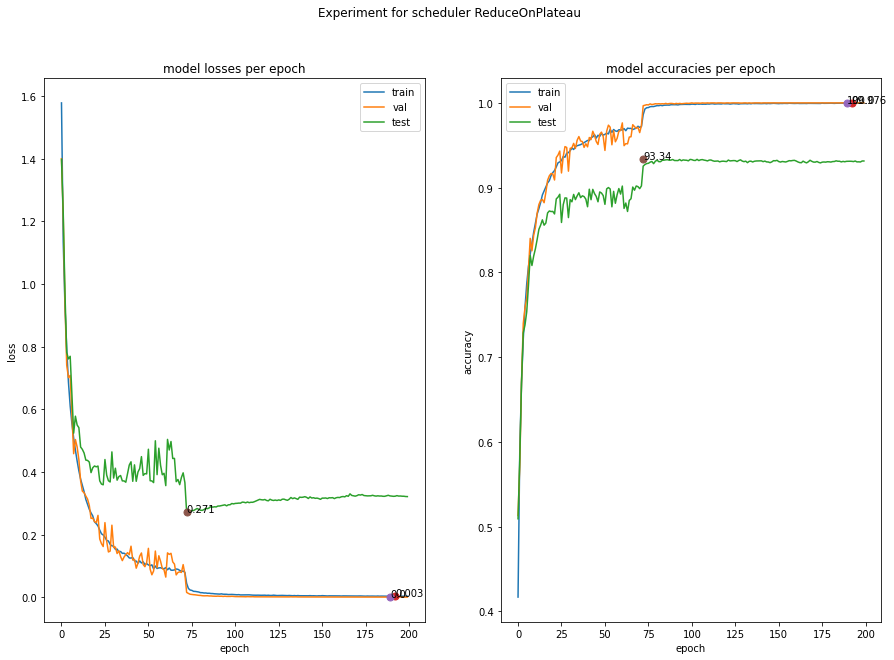

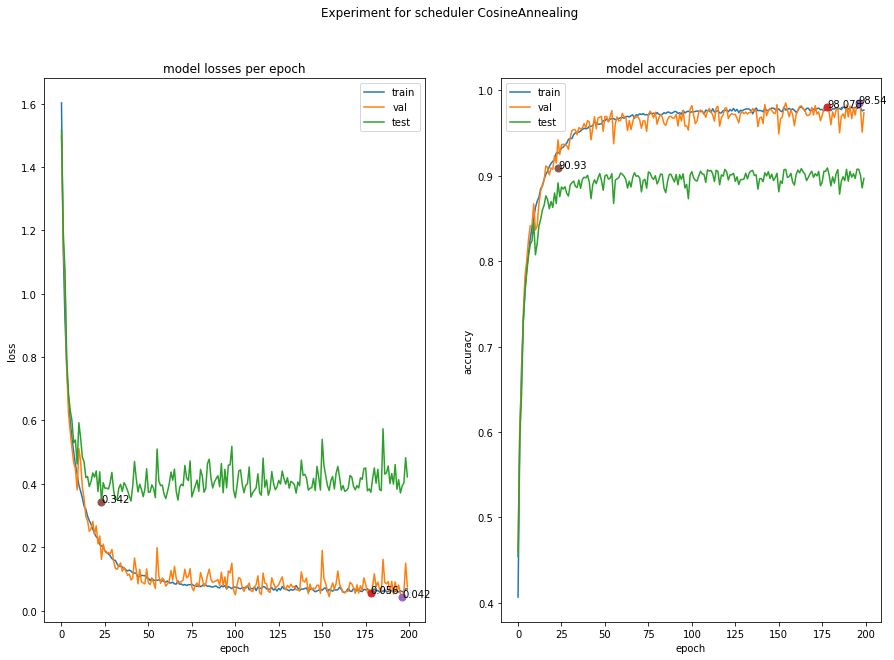

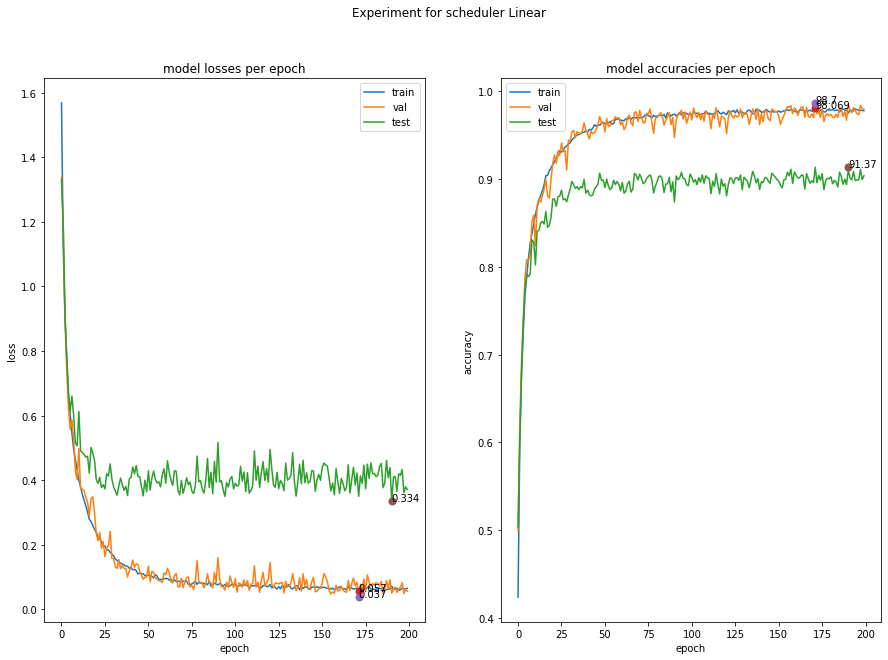

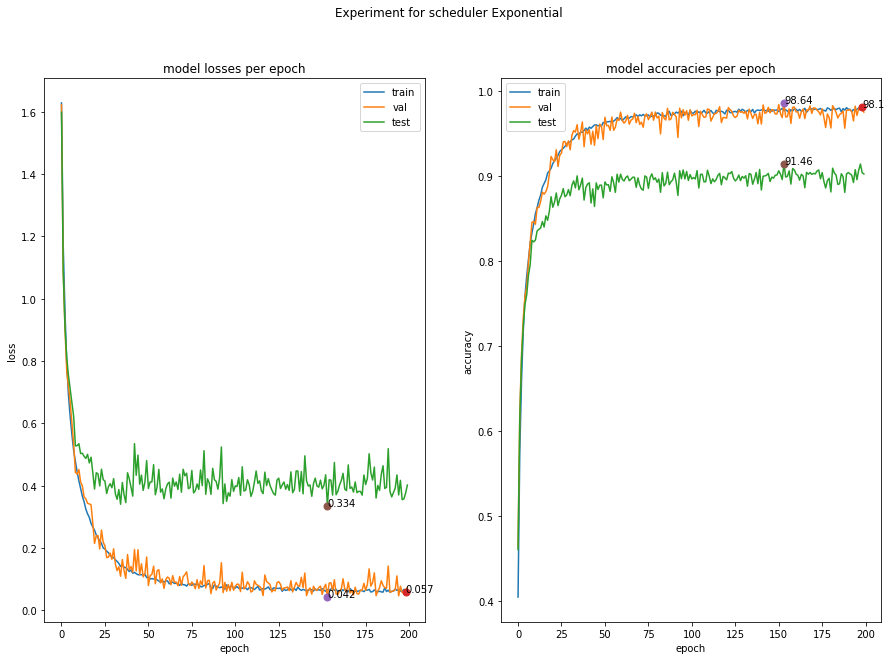

In [27]:
# Execute Experiment
n_epochs = 200

# Uncomment the type of experiment to run and comment the rest
# exp_type = 'epoch'
# exp_type = 'learning_rate'
# exp_type = 'optimizer'
# exp_type = 'batch_size'
exp_type = 'scheduler'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#create a parameter grid
hyperGrid = {
             'optimizer':['SGD', 'Adam', 'AdamW', 'RMSprop'],
             #'learning_rate':[1e-2, 1e-3, 1e-4, 1e-5],
             'batch_size':[32, 64, 128, 256],
             'scheduler':['ReduceOnPlateau', 'CosineAnnealing', 'Linear', 'Exponential']
            }

#Reset Seed
torch.manual_seed(SEED)

#Set up data loaders
train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True, num_workers=2, worker_init_fn = seed_worker, generator = g)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=False, num_workers=2, worker_init_fn = seed_worker, generator = g)

VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms
valid_dataloader = data.DataLoader(valid_data, batch_size=256, shuffle=True, worker_init_fn = seed_worker, generator = g)

#Get model
model = build_model()
model = model.to(device)


#set up default optimizer and criterion
optimizer = optim.SGD(model.parameters(), lr = 0.1, weight_decay= 0.0001, momentum = 0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)


#run experiments

experiment_training(n_epochs,  #epochs
                    model,
                    train_dataloader, 
                    valid_dataloader, 
                    test_dataloader, 
                    optimizer,
                    scheduler, 
                    criterion,
                    device,
                    hyperGrid,
                    exp_type)
